<a href="https://colab.research.google.com/github/ayoubbensakhria/wqu690/blob/master/VIX_futures_term_struct_trading_strategy_WQU690_Capstone_Experiment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Strategy Overview

## Experiment 2
### Add special Trade Technical Setup
*   VIX is below 17% -> Long, 
*   VIX is above 17% -> Short.

# 2. Install and import the required libraries

In [978]:
import warnings
warnings.filterwarnings('ignore')
# Yahoo finance data library
!pip install yfinance
# Technical indicators library
!pip install talib-binary
# Backtesting
!pip install backtrader
# Pyfolio
!pip install pyfolio

In [979]:
import math
import numpy as np
import pandas as pd
import yfinance as yf
import talib as tb
from datetime import date, timedelta, datetime
from dateutil import parser
from matplotlib import pyplot as plt
from sklearn.datasets import load_iris
from sklearn.tree import export_text
from sklearn import tree, datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, classification_report, accuracy_score
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (24, 12)
plt.style.use('fivethirtyeight')

# 2. Download Data
## 2.1. VIX Futures Term Structure Historical Data

In [980]:
# Dates Setup
start_date = date(2016, 3, 1)
end_date = date(2022, 4, 8)

To calculate the current level of contango we use the following formula: 

\begin{equation}
\mathrm{Ct}_{\mathrm{M}_{\mathrm{i}}, \mathrm{M}_{\mathrm{i}+1}}=\frac{\left(\mathrm{FVIX}_{\mathrm{M}_{\mathrm{i}+1}}-\mathrm{FVIX}_{\mathrm{M}_{\mathrm{i}}}\right) \cdot 100}{\mathrm{FVIX}_{\mathrm{M}_{\mathrm{i}}}}
\end{equation}

Where:

- $\mathrm{Ct}_{\mathrm{M}_{\mathrm{j}}, \mathrm{M}_{\mathrm{i}+1}}$ is % Contango between month $\mathrm{M}_{\mathrm{i}+1}$ and month $\mathrm{M}_{\mathrm{i}}$ VIX Futures.
- $\mathrm{FVIX}_{\mathrm{M}_{\mathrm{i}+1}}$ and FVIX $\mathrm{M}_{\mathrm{i}}$ are VIX future values at month $\mathrm{M}_{\mathrm{i}+1}$ and $\mathrm{M}_{\mathrm{i}}$ respectively.



In [981]:
# Get VIX Futures Term Structure Historical Data
vix_futures_csv = 'https://raw.githubusercontent.com/ayoubbensakhria/wqu690/master/data/vix_futures.csv'
df = pd.read_csv(vix_futures_csv, parse_dates=True)
# reverse df
df = df[::-1]
# set df index
df.index = pd.to_datetime(df['Date']).dt.date
# Drop unwanted columns for the current Experiment
columns_drop = ['Date', 'VXX', 'M1 Weight', 'M2 Weight', 'Weighted M1 M2', 'HV5', 'HV10', 'HV20', 'HV30', 'HV60', 'VVIX', 'VXX Bias', 'VRP', 'VIX GEX']
df.drop(columns_drop, axis=1, inplace=True)
# rename VIX3M
df.rename(columns={"VIX3M": "M3"}, inplace=True)
# Get data between start & end dates
mask = (df.index >= start_date) & (df.index< end_date)
df = df[mask]
# Compute Contango values
df['contango_m1'] = (df['M1'] - df['VIX'])*100/df['VIX']
df['contango_m2'] = (df['M2'] - df['M1'])*100/df['M1']
df['contango_m3'] = (df['M3'] - df['M2'])*100/df['M2']
df.head()

,VIX,M1,M2,M3,SPX,contango_m1,contango_m2,contango_m3
Date,,,,,,,,
2016-03-01,17.70,19.40,20.30,20.28,1978.35,9.604520,4.639175,-0.098522
2016-03-02,17.09,19.30,20.25,19.92,1986.45,12.931539,4.922280,-1.629630
2016-03-03,16.70,18.35,19.50,19.49,1993.40,9.880240,6.267030,-0.051282
2016-03-04,16.86,18.95,20.00,19.63,1999.99,12.396204,5.540897,-1.850000
2016-03-07,17.35,18.60,19.80,19.90,2001.76,7.204611,6.451613,0.505051


In [982]:
print(len(df))

1539


## 2.2. Download IXIC Historical Data and Join Dataframes

In [983]:
ixic = yf.download(tickers='^IXIC', start=start_date, end=end_date, interval="1d")
columns_drop = ['Close', 'High', 'Low', 'Open', 'Volume']
ixic.drop(columns_drop, axis=1, inplace=True)
# rename IXIC
ixic.rename(columns={"Adj Close": "IXIC"}, inplace=True)
# Join df to the left of IXIC
df = df.join(ixic)
df.head()

[*********************100%***********************]  1 of 1 completed


,VIX,M1,M2,M3,SPX,contango_m1,contango_m2,contango_m3,IXIC
Date,,,,,,,,,
2016-03-01,17.70,19.40,20.30,20.28,1978.35,9.604520,4.639175,-0.098522,4689.600098
2016-03-02,17.09,19.30,20.25,19.92,1986.45,12.931539,4.922280,-1.629630,4703.419922
2016-03-03,16.70,18.35,19.50,19.49,1993.40,9.880240,6.267030,-0.051282,4707.419922
2016-03-04,16.86,18.95,20.00,19.63,1999.99,12.396204,5.540897,-1.850000,4717.020020
2016-03-07,17.35,18.60,19.80,19.90,2001.76,7.204611,6.451613,0.505051,4708.250000


# 3. Compute Moving average convergence divergence (MACD) for SPX and IXIC 

MACD, short for moving average convergence/divergence, is a trading indicator used in technical analysis of stock prices.

MACD tells us about the convergence and divergence of the two moving averages. Convergence occurs when the moving averages move towards each other. Divergence occurs when the moving averages move away from each other.

In [984]:
df['spx_macd'], df['spx_signal'], df['spx_hist'] = tb.MACDFIX(df['SPX'])
df['ixic_macd'], df['ixic_signal'], df['ixic_hist'] = tb.MACDFIX(df['IXIC'])
df = df.dropna()
df.head()

,VIX,M1,M2,M3,SPX,contango_m1,contango_m2,contango_m3,IXIC,spx_macd,spx_signal,spx_hist,ixic_macd,ixic_signal,ixic_hist
Date,,,,,,,,,,,,,,,
2016-04-18,13.35,13.83,16.22,16.51,2094.34,3.595506,17.281273,1.787916,4960.020020,20.304154,20.196193,0.107961,58.506234,57.023238,1.482997
2016-04-19,13.24,13.25,16.22,16.47,2100.80,0.075529,22.415094,1.541307,4940.330078,21.249709,20.406896,0.842813,57.491694,57.116929,0.374765
2016-04-20,13.28,16.45,17.90,16.60,2102.40,23.870482,8.814590,-7.262570,4948.129883,21.874093,20.700335,1.173758,56.632215,57.019986,-0.387771
2016-04-21,13.95,16.80,18.45,17.14,2091.48,20.430108,9.821429,-7.100271,4945.890137,21.299931,20.820254,0.479676,55.151357,56.646260,-1.494903
2016-04-22,13.22,16.20,18.00,16.64,2091.58,22.541604,11.111111,-7.555556,4906.229980,20.616372,20.779478,-0.163106,50.392068,55.395422,-5.003354


## 2.3. Plot data

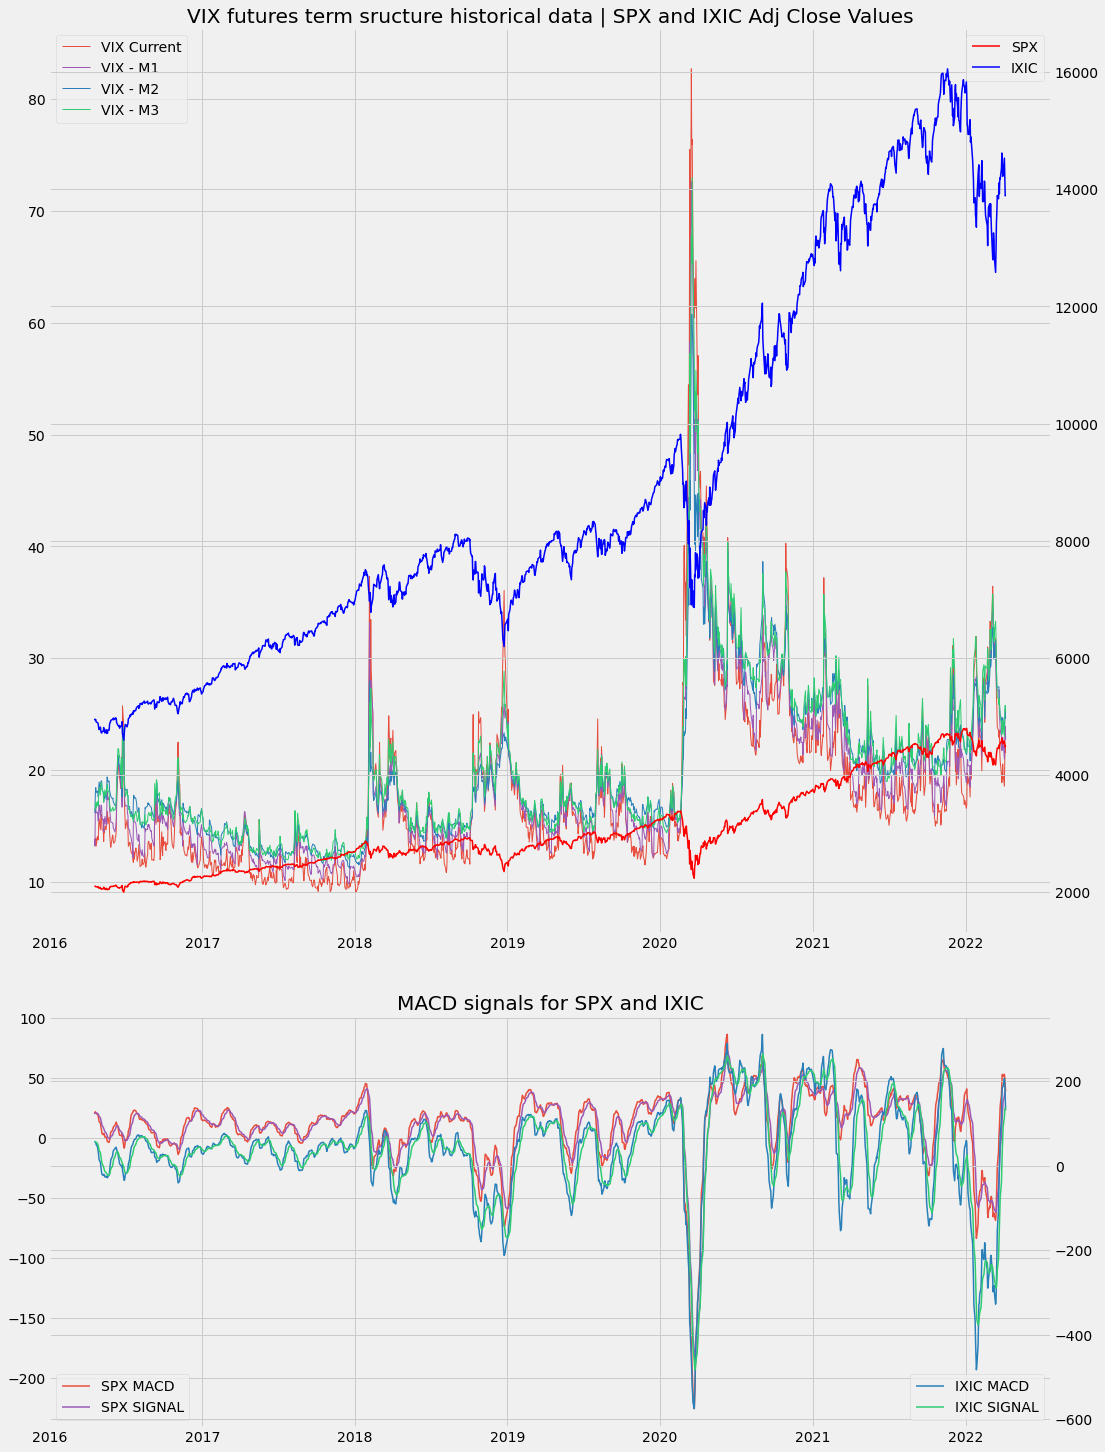

In [985]:
# Info: (x1, y1), (x2, y2)
# x1: number of rows, y1: number of columns 
# x2: row number, y2: column number
# documentation -> https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.subplot2grid.html
# Axe VIX with M1, M2, M3 maturities
plt.figure(figsize=(16,24))
vix_values = plt.subplot2grid((3, 1), (0,0),  colspan = 1, rowspan = 2)
vix_values.plot(df['VIX'], color = '#E74C3C', linewidth = 1,  label = 'VIX Current')
vix_values.plot(df['M1'], color = '#9B59B6', linewidth = 1, label = 'VIX - M1')
vix_values.plot(df['M2'], color = '#2980B9', linewidth = 1, label = 'VIX - M2')
vix_values.plot(df['M3'], color = '#2ECC71', linewidth = 1,  label = 'VIX - M3')
plt.legend(loc = 'upper left')
# Axe prices: SPX and IXIC Close Prices
axe_prices = vix_values.twinx()
axe_prices.plot(df['SPX'], color = 'red', linewidth = 1.5, label = 'SPX')
axe_prices.plot(df['IXIC'], color = 'blue', linewidth = 1.5, label = 'IXIC')
# add titles to subplots
axe_prices.set_title('VIX futures term sructure historical data | SPX and IXIC Adj Close Values')
# set legend position
plt.legend(loc = 'upper right')
# Plot MACD
axe_spx_macd = plt.subplot2grid((3, 1), (2,0),  colspan = 1)
axe_spx_macd.plot(df['spx_macd'], color = '#E74C3C', linewidth = 1.5, label = 'SPX MACD')
axe_spx_macd.plot(df['spx_signal'], color = '#9B59B6', linewidth = 1.5, label = 'SPX SIGNAL')
plt.legend(loc = 'lower left')
axe_ixic_macd = axe_spx_macd.twinx()
axe_ixic_macd.plot(df['ixic_macd'], color = '#2980B9', linewidth = 1.5, label = 'IXIC MACD')
axe_ixic_macd.plot(df['ixic_signal'], color = '#2ECC71', linewidth = 1.5, label = 'IXIC SIGNAL')
axe_ixic_macd.set_title('MACD signals for SPX and IXIC')
plt.legend(loc = 'lower right')

# 3. Compute IXIC trading entry positions

We compute IXIC entry positions on each point based on the next $l$ historical prices, determined risk:reward ratio, and our profit target.


Entry positions (signals) can have one of the following values: -1 (Sell), 1 (Buy), 0 (No Trade). These values will be used as target values to train our model.

To compute signal values from the next l prices we use the following formula:

\begin{equation}
\mathrm{E}_{\mathrm{t}, 1}=\operatorname{sgn}\left(\log \left(\left|\frac{\frac{\max _{\mathrm{t} \leq i \leq t+l} p_{i}-p_{t}}{p_{t}}}{\frac{\min _{t \leq i \leq t+l} p_{i}-p_{t}}{p_{t}}}\right|\right)\right)
\end{equation}

Where $\mathrm{E}_{\mathrm{t}, 1}$ is the trading signal at $t$ computed using the next $l$ values.

sgn is defined as follows:

\begin{equation}
\operatorname{sgn}: \mathbb{R} \rightarrow\{-1,0,1\}
\end{equation}

\begin{equation}
x \mapsto \operatorname{sgn}(x)=\left\{\begin{array}{cc}
-1 & \text { if } x \leq \mathrm{T} \text { and } \frac{\max _{\mathrm{t} \leq i \leq t+l} p_{i}-p_{t}}{p_{t}}<\mathrm{s} \\
1 & \text { if } x \geq \mathrm{T} \text { and } \frac{\min _{t \leq i \leq t+l} p_{i}-p_{t}}{p_{t}}>-\mathrm{s} \\
0 & \text { Otherwise }
\end{array}\right.
\end{equation}
- $\max _{t \leq i \leq t+l} p_{i}:$ the maximum price value of the vector containing the next $l$ historical prices including the current price.
- $\min _{t \leq i \leq t+l} p_{i}:$ the minimum price value of the vector containing the next $l$ historical prices including the current price.
- $T$ : is the Log of the targeted returns Abs(Max/Min) ratio.
- $p_{t}$ : is the price at time $\mathrm{t}$ (the current price).
- $\mathrm{s}$ is the rolling Log returns standard deviation: $s=\sqrt{\frac{1}{l-t} \sum_{i=t}^{l}\left(x_{i}-\bar{x}\right)^{2}}$

## Note
- The signals are rejected if no technical setup 
- Signals become null (0) whenever our rolling price vector contains Drawdowns or Peaks (returns above or bellow specific stop-loss points).

## 3.1. Implement Signal Function

###3.1.1. Compute Risk

In [986]:
# Standard Deviation 
df['Change'] = (df['IXIC']-df['IXIC'].shift(-1))/df['IXIC'].shift(-1)
# compute the risk (std) and the target return
risk = df['Change'].std(skipna=True)
df.drop('Change', axis = 1, inplace=True)
# Define reward/risk coeff
reward_risk_coeff = 3

In [987]:
def sign (df, lags):  #<- lags = historical prices ahead of the current position
  # calculte rolling min and max prices (after the possible entrypoints)
  next_highest_price = df['IXIC'].rolling(lags).max().shift(-lags)
  next_lowest_price = df['IXIC'].rolling(lags).min().shift(-lags)
  # Filter entrypoints before building the model
  df['rolling_max_return'] = ((next_highest_price - df['IXIC']) / df['IXIC'])
  df['rolling_min_return'] = ((next_lowest_price - df['IXIC']) / df['IXIC'])
  #Compute E(t,l) = df['ep']
  df['ep'] = np.log(abs(df['rolling_max_return']/df['rolling_min_return']))
  # drop the last (lags) rows
  df = df[lags:]
  # generate signals for the training dataset
  # signal is +1 if the max price is above the target rate and the min price is above the risk 
  df['tsignal'] = df.apply(
      lambda row: 1 
      if (
          row['ep'] > math.log(reward_risk_coeff) 
          and row['rolling_min_return'] > -risk
          ) 
      else 0, axis =1)
  
  df['atsignal'] = df.apply(
      lambda row: -1 
      if (
          row['ep'] <= -math.log(reward_risk_coeff) 
          and row['rolling_max_return'] < risk
          ) 
      else 0, axis =1)
  
  # Merge sell signals and drop atsignals
  df['tsignal'].loc[df.tsignal==0] = df.loc[df.tsignal==0]['atsignal']
  # Drop unnecessary features
  df.drop(['atsignal', 'rolling_max_return', 'rolling_min_return', 'ep'] , axis=1, inplace=True)
  # drop nans after replacing infinity
  df.replace([np.inf, -np.inf], np.nan, inplace=True)
  df.dropna(inplace=True)
  return df
# lags value here l = 7, profit/loss = 5
df = sign(df, 7)

### 3.1.2. Compute optimal technical setup for our strategy

In [988]:
def reject_outliers(data, m=6.0):
    return data[abs(data - np.mean(data)) < m * np.std(data)]

buy_vix_limit = reject_outliers(df.loc[df.tsignal==1]['VIX']).mean()
sell_vix_limit = reject_outliers(df.loc[df.tsignal==-1]['VIX']).mean()

print('Buy VIX Below', buy_vix_limit)
print('Sell VIX Above', sell_vix_limit)

Buy VIX Below 17.597850953206237
Sell VIX Above 17.249150684931482


Tweak signals 

In [989]:
###########################################
# Reject signals if invalid technical setup
###########################################

df['_tsignal'] = df.apply(
    lambda row: 1 if (
        row['tsignal'] == 1
        # Long when volatility is low
        and  row['VIX'] <= buy_vix_limit
        #and  buy_macd_entry <= row['spx_macd'] <= buy_macd_max
        )
        else 0, 
        axis =1)

df['_atsignal'] = df.apply(
    lambda row: -1 if (
        row['tsignal'] == -1
        # Long when volatility is low
        and row['VIX'] >= sell_vix_limit
        #and sell_macd_min <= row['spx_macd'] <= sell_macd_entry
        )
        else 0, 
        axis =1)

# Merge Long and Short signals 
df['_tsignal'].loc[df._tsignal==0] = df.loc[df._tsignal==0]['_atsignal']
df['tsignal'] = df['_tsignal']
df.drop(['_tsignal', '_atsignal'], axis = 1, inplace=True)
print('LONG SIGNALS COUNT', len(df.loc[df['tsignal']== 1]))
print('SHORT SIGNALS COUNT', len(df.loc[df['tsignal']== -1]))


LONG SIGNALS COUNT 365
SHORT SIGNALS COUNT 151


## 3.2. Plot actual signals

In [990]:
def plot_signals(df, title, ylabel):
  # Initialize the plot figure
  fig = plt.figure(figsize=(32,16))

  partddf = df[-200:]
  ## Add a subplot and label for y-axis
  axe_predictions = fig.add_subplot(111,ylabel=ylabel)

  ## Plot the closing price
  partddf['IXIC'].plot(ax=axe_predictions, color='#2ECC71', lw=5.)

  # Plot the buy signals
  axe_predictions.plot(partddf.loc[partddf.tsignal == 1.0].index, 
          partddf.IXIC[partddf.tsignal == 1.0],
          '^', markersize=10, color='b')

  # Plot the sell signals
  axe_predictions.plot(partddf.loc[df.tsignal == -1.0].index, 
          partddf.IXIC[df.tsignal == -1.0],
          'v', markersize=10, color='r')
  # Display plt
  axe_predictions.set_title(title)
  plt.show()

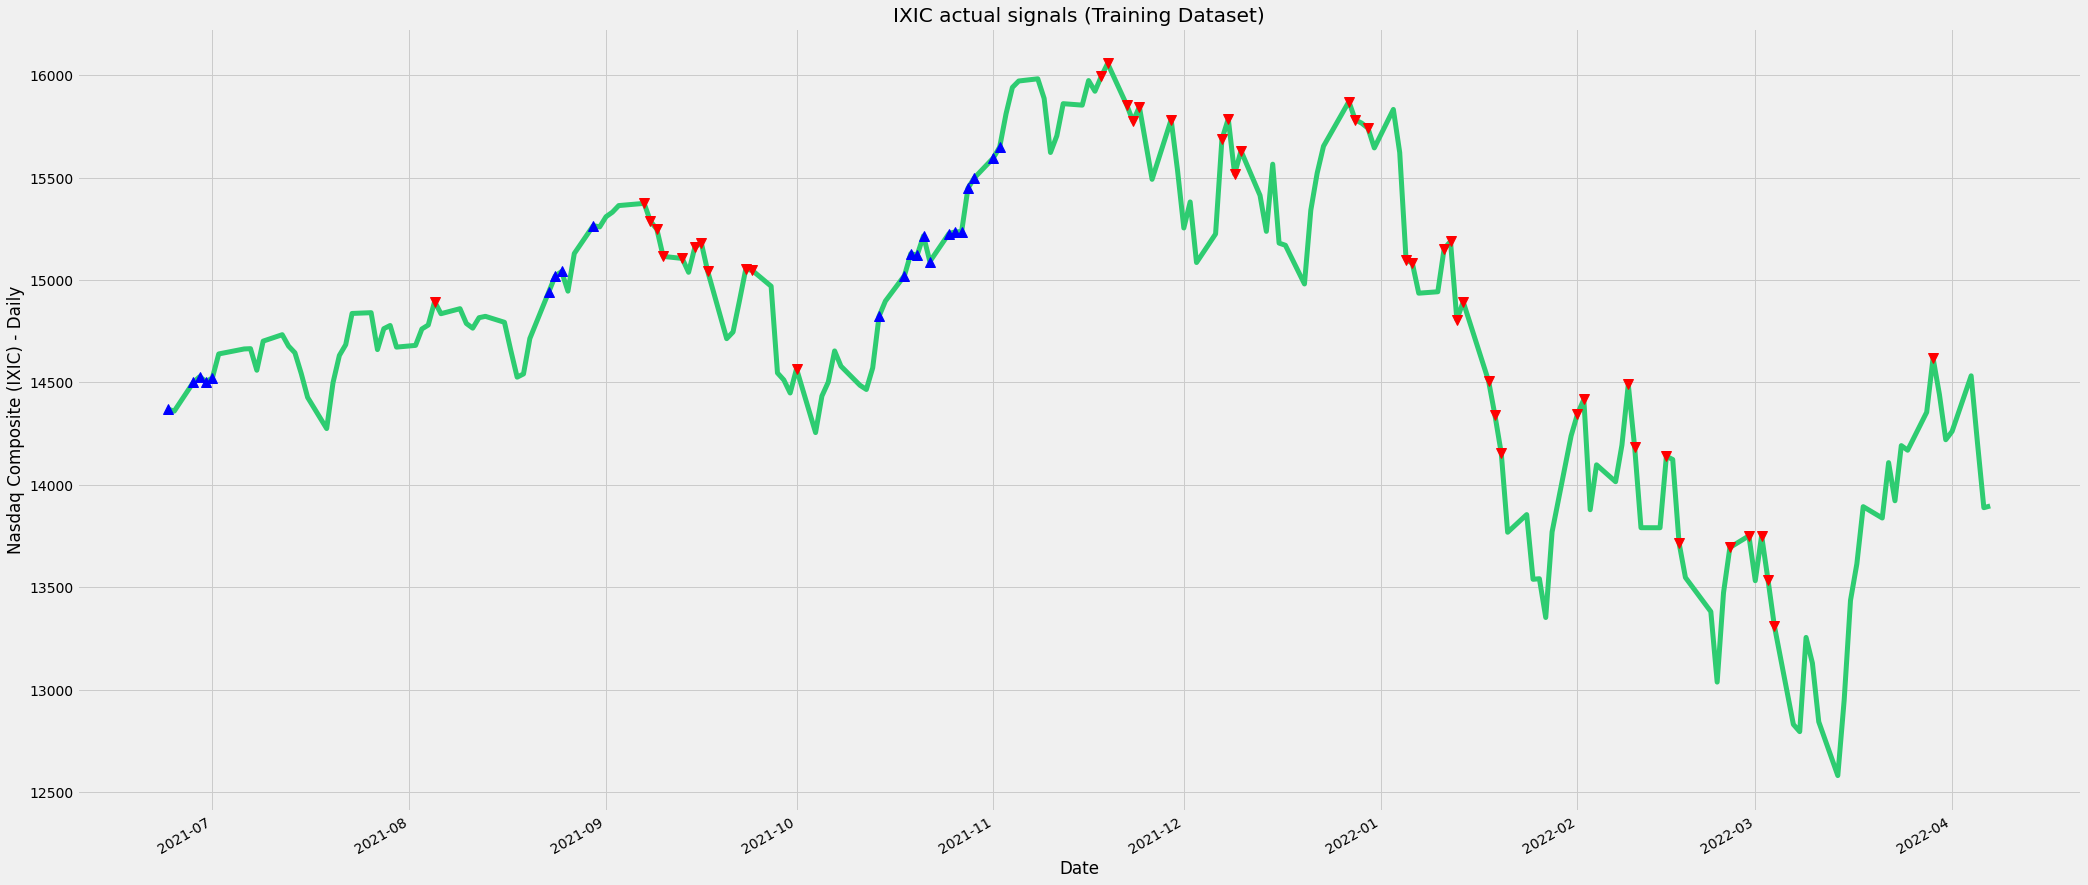

In [991]:
ylabel = 'Nasdaq Composite (IXIC) - Daily'
title = 'IXIC actual signals (Training Dataset)'
plot_signals(df, title, ylabel)

# 4. Implement Random Forrest Model
Train, Hyperparameter tuning, performance score, Crossvalidation score

In [992]:
# Specify features
feature_names = list(df.columns)
non_features = ['tsignal', 'IXIC'] 
for nf in non_features:
  feature_names.remove(nf)
print(feature_names)

['VIX', 'M1', 'M2', 'M3', 'SPX', 'contango_m1', 'contango_m2', 'contango_m3', 'spx_macd', 'spx_signal', 'spx_hist', 'ixic_macd', 'ixic_signal', 'ixic_hist']


In [1003]:
# train the RFC model
X = df[feature_names]
y = df['tsignal']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, shuffle=True)

rfc = RandomForestClassifier(random_state=100)

rfc = rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
report = classification_report(y_test, y_pred)
print('Model accuracy', accuracy_score(y_test, y_pred, normalize=True))
print ('Cross Val score', np.mean(cross_val_score(rfc, X_train, y_train, cv=10)))
print(report)

Model accuracy 0.74
Cross Val score 0.7356442577030813
              precision    recall  f1-score   support

          -1       0.82      0.30      0.44        30
           0       0.74      0.92      0.82       191
           1       0.73      0.48      0.58        79

    accuracy                           0.74       300
   macro avg       0.76      0.57      0.61       300
weighted avg       0.74      0.74      0.72       300



## 4.1. Hyperparameter tuning GridSearchCV (Optional)
Takes time

In [994]:
"""
param_dict = {
    "criterion": ['gini', 'entropy'],
    "max_depth": range(1, 10),
    "min_samples_split": range(1, 10),
    "min_samples_leaf": range(1, 10)
}

grid = GridSearchCV(rfc, 
                    param_grid=param_dict,
                    cv = 3,
                    verbose = 1,
                    n_jobs = -1,
                    return_train_score=True)

grid.fit(X_train, y_train)
grid.best_estimator_
"""

'\nparam_dict = {\n    "criterion": [\'gini\', \'entropy\'],\n    "max_depth": range(1, 10),\n    "min_samples_split": range(1, 10),\n    "min_samples_leaf": range(1, 10)\n}\n\ngrid = GridSearchCV(rfc, \n                    param_grid=param_dict,\n                    cv = 3,\n                    verbose = 1,\n                    n_jobs = -1,\n                    return_train_score=True)\n\ngrid.fit(X_train, y_train)\ngrid.best_estimator_\n'

## 4.1. Model feature importance
The mean decrease in Gini coefficient is a measure of how each variable contributes to the homogeneity of the nodes and leaves in the resulting random forest. The higher the value of mean decrease accuracy or mean decrease Gini score, the higher the importance of the variable in the model.

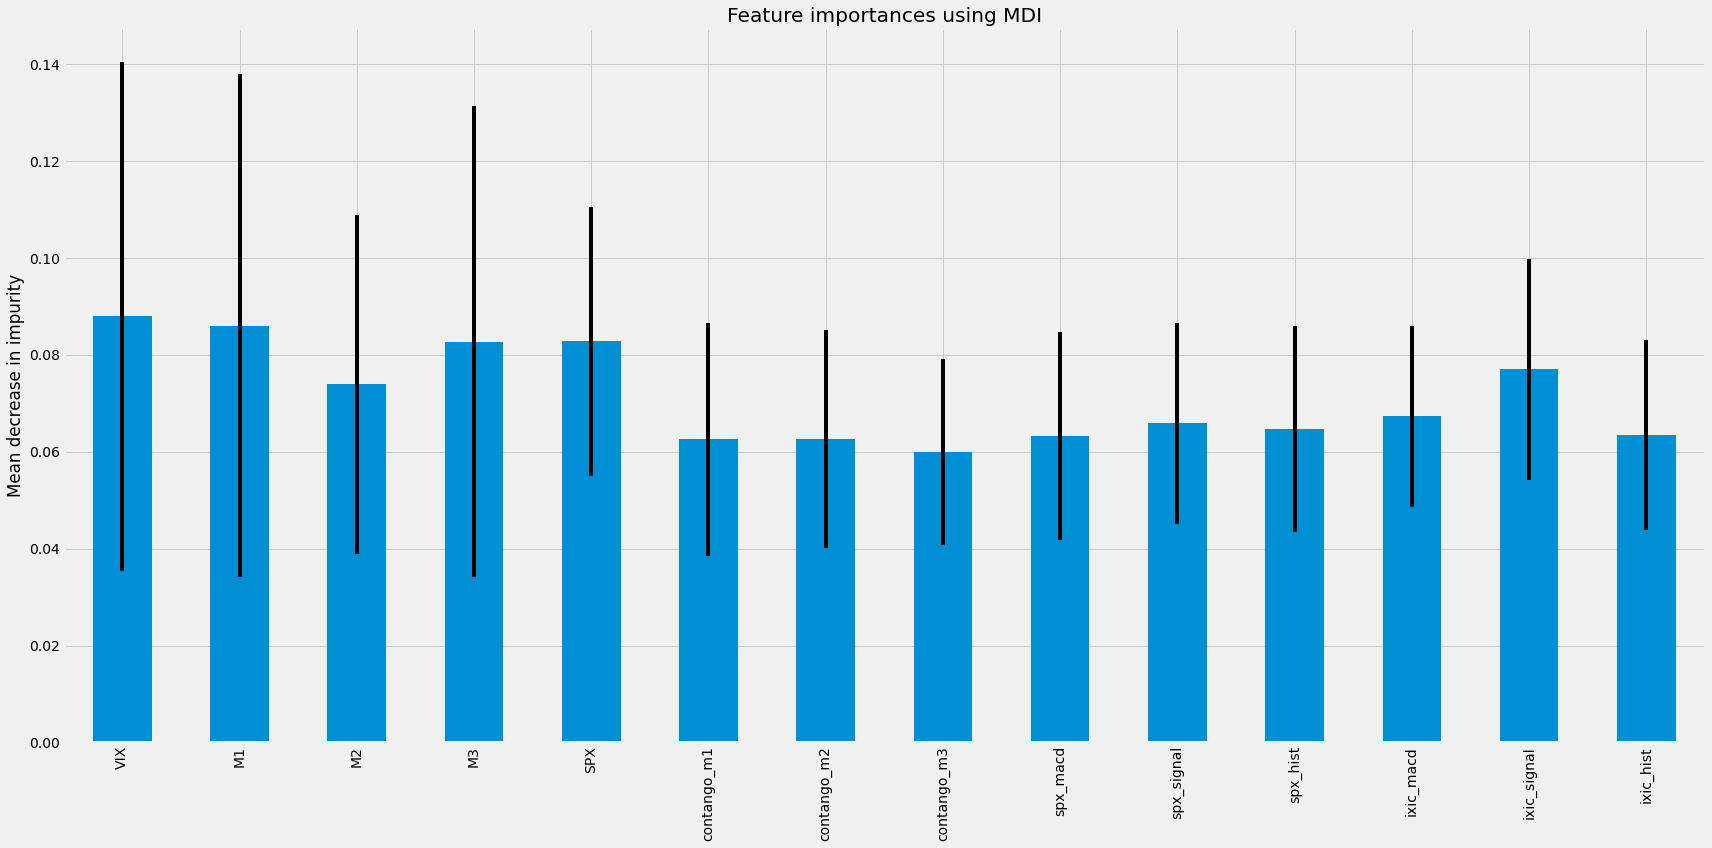

In [995]:
importances = rfc.feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
std = np.std([tree.feature_importances_ for tree in rfc.estimators_], axis=0)
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

## 4.2. Plot the signals

In [996]:
ddf = df.drop(non_features, axis=1)
ddf['predicted_signal'] = rfc.predict(ddf) 
ddf['IXIC'] = df['IXIC']
# reduce data (last 100 days)
display_days = 100
short_ddf = ddf[-display_days:]

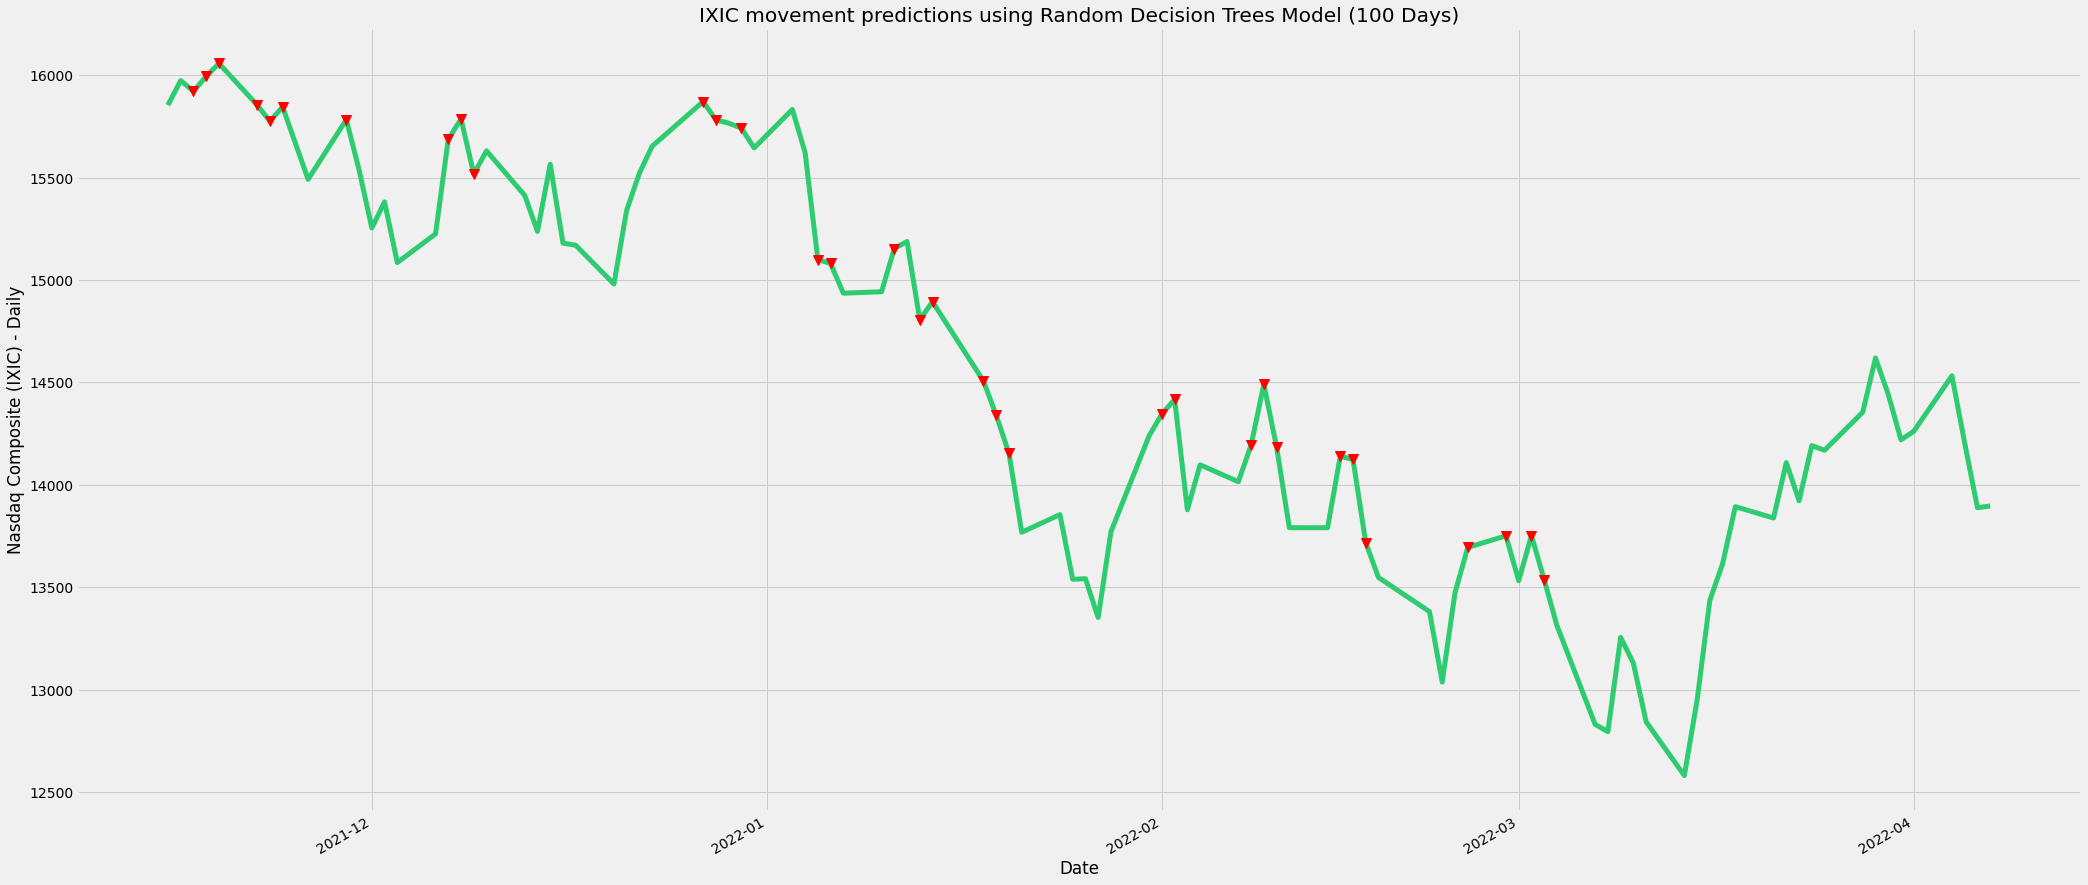

In [997]:
# Initialize the plot figure
fig = plt.figure(figsize=(32,16))

## Add a subplot and label for y-axis
axe_predictions = fig.add_subplot(111,ylabel='Nasdaq Composite (IXIC) - Daily')

## Plot the closing price
short_ddf['IXIC'].plot(ax=axe_predictions, color='#2ECC71', lw=5.)

# Plot the buy signals
axe_predictions.plot(short_ddf.loc[short_ddf.predicted_signal == 1.0].index, 
         short_ddf.IXIC[ddf.predicted_signal == 1.0],
         '^', markersize=10, color='b')

# Plot the sell signals
axe_predictions.plot(short_ddf.loc[short_ddf.predicted_signal == -1.0].index, 
         short_ddf.IXIC[ddf.predicted_signal == -1.0],
         'v', markersize=10, color='r')
# Display plt
axe_predictions.set_title('IXIC movement predictions using Random Decision Trees Model ({last_days} Days)'.format(last_days=display_days))
plt.show()

##4.3. Predictions in Contango vs Backwardation

In [998]:
TEST_LENGTH = len(X_test)
signalDf = pd.DataFrame({'actual_signal':df['tsignal'] , 'predicted_signal':ddf['predicted_signal'], 'contango_m1': df['contango_m1']})
# take only test Data
signalDf = signalDf[-TEST_LENGTH:]
contango = signalDf.loc[signalDf['contango_m1']>0]
backwardation = signalDf.loc[signalDf['contango_m1']<0]
print('Total signals: ', len(signalDf))
print('Contango Count:', len(contango))
print('Backwardation Count:', len(backwardation))
print('Accuracy in Contango (M1)', len(contango.loc[contango['predicted_signal'] == contango['actual_signal']])/len(contango))
print('Accuracy in Backwardation (M1)', len(backwardation.loc[backwardation['predicted_signal'] == backwardation['actual_signal']])/len(backwardation))
signalDf.head()

Total signals:  300
Contango Count: 244
Backwardation Count: 56
Accuracy in Contango (M1) 0.9344262295081968
Accuracy in Backwardation (M1) 1.0


,actual_signal,predicted_signal,contango_m1
Date,,,
2021-02-01,0,0,0.297619
2021-02-02,0,0,7.902973
2021-02-03,0,0,12.527281
2021-02-04,0,0,11.299954
2021-02-05,0,0,15.476761


# 5. Backtesting
## 5.1. Backtesting using Backtrader

In [999]:
%matplotlib inline
import backtrader as bt
import pyfolio as pf
from backtrader.feeds import PandasData
# download ticker ‘Adj Close’ price from yahoo finance
ticker = '^IXIC'
prices = yf.download(ticker, progress=True, actions=True,start=start_date, end=end_date)
stock =  prices['Adj Close']
stock = pd.DataFrame(stock)
# calculate daily log returns and market direction
stock['returns'] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
# rename the columns as needed for Backtrader
prices.drop(['Close', 'Dividends', 'Stock Splits'], inplace=True, axis=1)
prices.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume',
                         }, inplace=True)
# predictions
predictions = ddf.predicted_signal
predictions = pd.DataFrame(predictions)
predictions.rename(columns = {'predicted_signal':'predicted'}, inplace=True)
prices = predictions.join(prices, how='right').dropna()
prices.tail(2)

[*********************100%***********************]  1 of 1 completed


,predicted,open,high,low,close,volume
Date,,,,,,
2022-04-06,0.0,14002.580078,14032.839844,13788.900391,13888.820312,5265740000
2022-04-07,0.0,13861.490234,13978.250000,13689.230469,13897.299805,4822420000


In [1000]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']
# create lines
    lines = tuple(cols)
# define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [1001]:
class RFCStrategy(bt.Strategy):
    params = dict(
       # put parameters here (refer to the documentation) 
    )

    def __init__(self):
        self.data_predicted = self.datas[0].predicted  # This is the predicted value of our RFC
        self.data_close = self.datas[0].Close # Adjusted Close Price
        self.data_open = self.datas[0].Open
        # buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None
    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return
        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')
        # set no pending order
        self.order = None
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')
    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open}, Close: {self.data_close}')
                self.buy(size=size)
        else:
            if self.data_predicted < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)


In [1002]:
# instantiate SignalData class
data = SignalData(dataname=prices)
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(RFCStrategy)
cerebro.adddata(data, name= '^IXIC')
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2016-05-04, BUY CREATED --- Size: 21, Cash: 100000.00, Open: 3, Close: 0
2016-05-04, BUY EXECUTED --- Price: 4735.28, Cost: 99440.88,Commission: 99.44
2016-06-13, SELL CREATED --- Size: 21
2016-06-13, SELL EXECUTED --- Price: 4868.51, Cost: 99440.88,Commission: 102.24
2016-06-13, OPERATION RESULT --- Gross: 2797.83, Net: 2596.15
2016-06-30, BUY CREATED --- Size: 21, Cash: 102596.15, Open: 3, Close: 0
2016-06-30, BUY EXECUTED --- Price: 4793.75, Cost: 100668.75,Commission: 100.67
2018-03-19, SELL CREATED --- Size: 21
2018-03-19, SELL EXECUTED --- Price: 7419.20, Cost: 100668.75,Commission: 155.80
2018-03-19, OPERATION RESULT --- Gross: 55134.45, Net: 54877.98
2018-04-30, BUY CREATED --- Size: 22, Cash: 157474.13, Open: 3, Close: 0
2018-04-30, BUY EXECUTED --- Price: 7133.95, Cost: 156946.90,Commission: 156.95
2018-10-16, SELL CREATED --- Size: 22
2018-10-16, SELL EXECUTED --- Price: 7501.78, Cost: 156946.90,Commission: 165.04
2018-10-16, OPERATION RES

# 5.2. Performance Analysis of Backtesting
We will analyze the performance statistics using pyfolio . pyfolio is a Python library for performance and risk analysis of financial portfolios developed by Quantopian Inc.


Start date,2016-04-27
End date,2022-04-07
Total months,71
,Backtest
Annual return,18.7%
Cumulative returns,177.4%
Annual volatility,9.2%
Sharpe ratio,1.92
Calmar ratio,1.96
Stability,0.96
Max drawdown,-9.5%


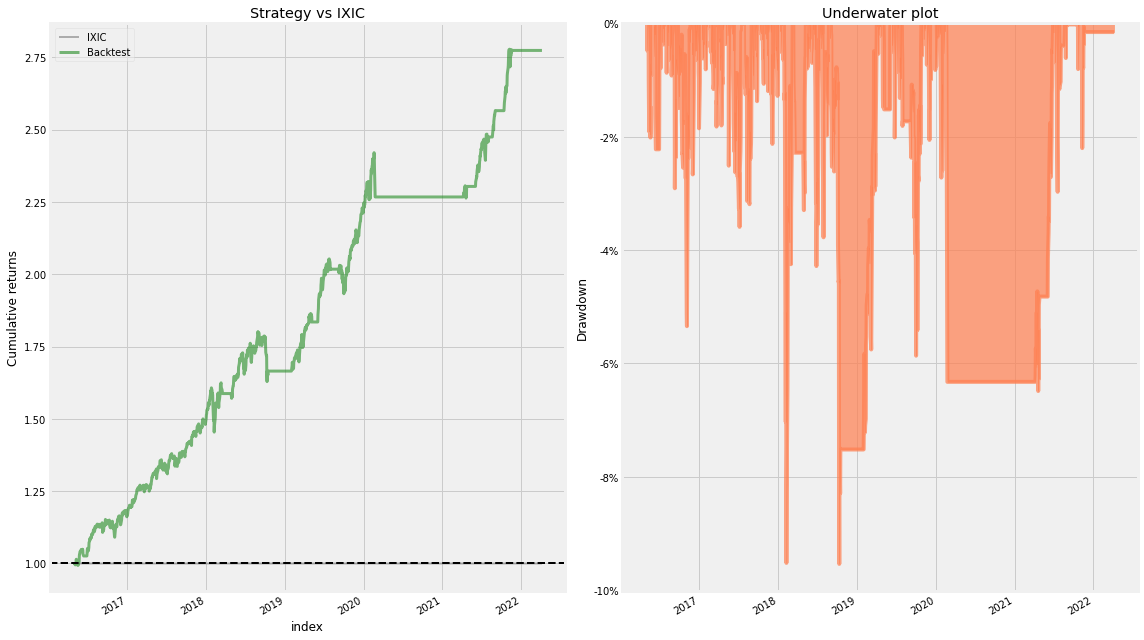

In [977]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
# get benchmark returns
benchmark_rets= stock['returns']
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'IXIC'
# get performance statistics for strategy
pf.show_perf_stats(returns)
# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()
pf.plot_rolling_returns(returns=returns,
                        factor_returns=benchmark_rets,
                        ax=axes[0], title='Strategy vs IXIC')
axes[0].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[1])
axes[1].grid(True)
# fig.suptitle('Strategy vs Nifty-50 (Buy and Hold)', fontsize=16, y=0.990)
plt.grid(True)
plt.tight_layout()